# Model 4: The Bates Model (Stochastic Volatility with Jumps)
## Objective: The "Holy Grail" of Classical Option Pricing

We have seen that **Merton** perfectly captures the short-term skew (by adding sudden jumps/crashes), but struggles with long-term options. 
We have seen that **Heston** perfectly captures the long-term skew (using mean-reverting stochastic volatility), but struggles to bend the curve enough for short-term crashes without using absurd parameters.

David Bates (1996) combined them into the **SVJ Model** (Stochastic Volatility with Jumps). 

### The Mathematical Intuition
The Bates model simply takes the two Heston SDEs and adds the Merton Poisson jump counter directly to the asset price process:

1. **The Asset Price Process (Heston + Merton):** $$\frac{dS_t}{S_t} = (\mu - \lambda k) dt + \sqrt{v_t} dW_t^S + (J_t - 1) dN_t$$

2. **The Variance Process (Standard Heston):** $$dv_t = \kappa(\theta - v_t)dt + \xi \sqrt{v_t} dW_t^v$$

Because the Heston diffusion process and the Merton jump process are mathematically independent, Bates realized you could simply multiply their Characteristic Functions together. This created a single, unified model that can price the entire Volatility Surface (short-term and long-term) flawlessly.

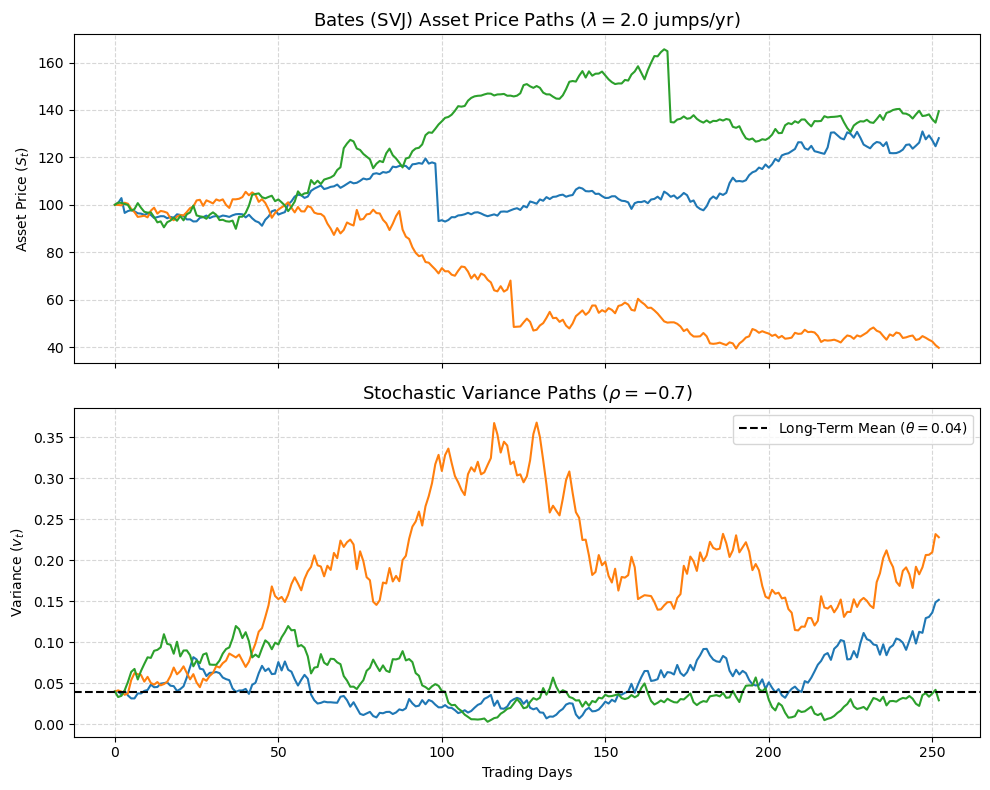

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Bates Simulation Parameters ---
S0 = 100.0
v0 = 0.04       # Initial Variance (20% Vol)
kappa = 2.0     # Speed of mean reversion
theta = 0.04    # Long-term variance
xi = 0.5        # Volatility of Volatility
rho = -0.7      # Negative correlation (Leverage effect)
r = 0.05
T = 1.0         # 1 Year
steps = 252     # Trading days
dt = T / steps
n_paths = 3     

# Jump Parameters (Merton)
lam = 2.0       # 2 jumps per year
mu_j = -0.15    # Average jump is a 15% drop
delta = 0.10    # Volatility of the jump size

np.random.seed(42)

# 1. Generate Correlated Brownian Motions (Heston part)
Z1 = np.random.standard_normal((steps, n_paths))
Z2 = np.random.standard_normal((steps, n_paths))
Z_S = Z1
Z_v = rho * Z1 + np.sqrt(1 - rho**2) * Z2

# 2. Generate Jumps (Merton part)
N = np.random.poisson(lam * dt, (steps, n_paths))
J = np.random.normal(mu_j, delta, (steps, n_paths))
k = np.exp(mu_j + 0.5 * delta**2) - 1

# 3. Setup Path Arrays
S = np.zeros((steps + 1, n_paths))
v = np.zeros((steps + 1, n_paths))
S[0] = S0
v[0] = v0

# 4. Euler-Maruyama Integration 
for t in range(1, steps + 1):
    # Variance Process (Heston)
    v_prev = np.maximum(v[t-1], 0)
    dv = kappa * (theta - v_prev) * dt + xi * np.sqrt(v_prev) * np.sqrt(dt) * Z_v[t-1]
    v[t] = np.maximum(v_prev + dv, 0)
    
    # Asset Price Process (Heston Diffusion + Merton Jumps)
    continuous_return = (r - lam * k) * dt + np.sqrt(v_prev) * np.sqrt(dt) * Z_S[t-1]
    jump_return = N[t-1] * J[t-1]
    
    S[t] = S[t-1] * np.exp(continuous_return + jump_return)

# --- Plotting the SVJ Paths ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Asset Price
ax1.plot(S, linewidth=1.5)
ax1.set_title(rf"Bates (SVJ) Asset Price Paths ($\lambda={lam}$ jumps/yr)", fontsize=13) 
ax1.set_ylabel("Asset Price ($S_t$)")
ax1.grid(True, linestyle='--', alpha=0.5)

# Plot Variance
ax2.plot(v, linewidth=1.5)
ax2.axhline(theta, color='black', linestyle='--', label=rf'Long-Term Mean ($\theta={theta}$)') 
ax2.set_title(rf"Stochastic Variance Paths ($\rho={rho}$)", fontsize=13)
ax2.set_xlabel("Trading Days")
ax2.set_ylabel("Variance ($v_t$)")
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()